In [1]:
!nvidia-smi

Fri Mar 24 17:14:27 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install transformers datasets evaluate wandb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.1/189.1 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... d

## Load Data and Libraries

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader

from transformers import ViTFeatureExtractor, ViTForImageClassification, AutoFeatureExtractor, ResNetForImageClassification
from transformers import TrainingArguments, Trainer
from datasets import load_metric, DatasetDict, Dataset, load_dataset

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import wandb
import numpy as np
import os
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#!unzip '/content/drive/MyDrive/lsd/lsdd.zip' -d '/content/drive/MyDrive/lsd'

In [7]:
# datasets = load_dataset('imagefolder', data_dir='/content/drive/MyDrive/files/data2')
# datasets = datasets['train'].train_test_split(test_size=.2, seed=42)

# datasets_split = datasets['train'].train_test_split(test_size=.2, seed=42)
# datasets['train'] = datasets_split['train']
# datasets['validation'] = datasets_split['test']

# datasets

In [8]:
datasets = load_dataset('imagefolder', data_dir='/content/drive/MyDrive/lsd/lsdd')

Resolving data files:   0%|          | 0/681 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/149 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/145 [00:00<?, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /root/.cache/huggingface/datasets/imagefolder/default-1016115821a545f9/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
datasets

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 681
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 149
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 145
    })
})

In [10]:
labels = datasets['train'].features['label'].names
labels

['Lumpy Skin', 'Normal Skin']

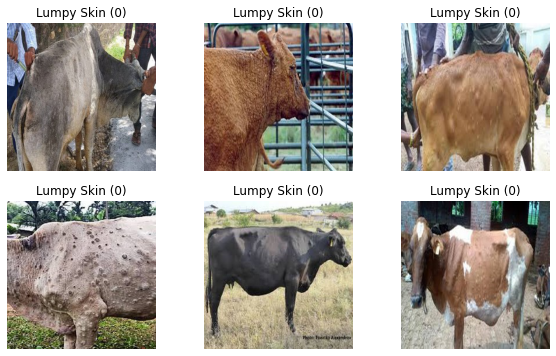

In [11]:
# plot samples
samples = datasets['train'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"{labels[samples[pointer]['label']]} ({samples[pointer]['label']})")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

## ViT - Vision Transformer

In [12]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [13]:
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:
extractor(samples[0]['image'], return_tensors='pt')
# there are a lot of ones bcs the background of imgs are white, so its normal

{'pixel_values': tensor([[[[-0.8039,  0.0902,  0.3255,  ..., -0.4902, -0.3961, -0.3804],
          [-0.6706,  0.1529,  0.2157,  ..., -0.5294, -0.4275, -0.3490],
          [-0.4431,  0.1451,  0.1608,  ..., -0.5137, -0.4353, -0.3255],
          ...,
          [-0.1843, -0.2627, -0.3176,  ..., -0.1137, -0.0196,  0.0118],
          [-0.1529, -0.4118, -0.3882,  ..., -0.0196, -0.0196,  0.0196],
          [-0.2863, -0.4510, -0.3333,  ...,  0.0118,  0.0510, -0.0353]],

         [[-0.7255,  0.1843,  0.4588,  ..., -0.5529, -0.5294, -0.6549],
          [-0.5922,  0.2471,  0.3490,  ..., -0.5922, -0.5451, -0.6000],
          [-0.3569,  0.2471,  0.3020,  ..., -0.5686, -0.5294, -0.5529],
          ...,
          [-0.2706, -0.3490, -0.4118,  ..., -0.0667,  0.0118,  0.0353],
          [-0.2235, -0.4902, -0.4745,  ...,  0.0275,  0.0118,  0.0431],
          [-0.3569, -0.5216, -0.4118,  ...,  0.0588,  0.0824, -0.0118]],

         [[-0.4510,  0.5294,  0.8039,  ..., -0.4667, -0.3961, -0.4588],
          [-0

In [15]:
def batch_transform(examples):
    # take a list of PIL images and turn into pixel values
    inputs = extractor([x for x in examples['image']], return_tensors='pt')
    # add the labels in
    inputs['label'] = examples['label']
    
    return inputs

In [16]:
transformed_data = datasets.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 681
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 149
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 145
    })
})

In [17]:
# data collator
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.tensor([x['label'] for x in examples])
    }

# metrics
metric = load_metric('accuracy')
def compute_metrics(p):
    labels = p.label_ids
    preds = p.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1
    }
#     return metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)

<ipython-input-17-857bab8653ad>:9: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('accuracy')


### Zero-shot

In [18]:
model = ViTForImageClassification.from_pretrained(model_ckpt,
                                                 num_labels=len(labels),
                                                 id2label={str(i): c for i, c in enumerate(labels)},
                                                 label2id={c: str(i) for i, c in enumerate(labels)})
model = model.to(device)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
zero_loader = DataLoader(transformed_data['test'], batch_size=16)
zero_pred = []
for batch in tqdm(zero_loader):
    with torch.no_grad():        
        logits = model(batch['pixel_values'].to(device)).logits
        pred = logits.argmax(-1).cpu().detach().tolist()
        zero_pred += [labels[i] for i in pred]

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
zero_true = [labels[i] for i in datasets['test']['label']]

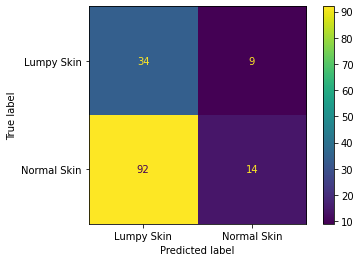

In [21]:
cm = confusion_matrix(zero_true, zero_pred, labels=labels)
disp = ConfusionMatrixDisplay(cm, display_labels=labels)
disp.plot()
plt.show()

In [22]:
print(f'ViT zero-shot Acc: {accuracy_score(zero_true, zero_pred):.3f}')
print(f'ViT zero-shot F1: {f1_score(zero_true, zero_pred, average="weighted"):.3f}')

ViT zero-shot Acc: 0.322
ViT zero-shot F1: 0.271


### Fine Tuning

In [23]:
vit_config = dict(learning_rate = 1e-5,
                  architecture = 'ViT',
                  dataset_id = 'lsd',
                  infra='kaggle')

run = wandb.init(project='lssd',
                notes='SMLT course project',
                tags=['comparison', 'ViT', 'ResNet'],                 
                config=vit_config,
                name='hf-ViT-base-16-224')

wandb: Currently logged in as: cbtest201 (cbtest). Use `wandb login --relogin` to force relogin


In [24]:
# train props
batch_size = 16
logging_steps = len(transformed_data['train']) // batch_size

In [25]:
training_args = TrainingArguments(output_dir='/content/wandb',
                                 report_to='wandb',
                                 per_device_train_batch_size=batch_size,
                                 per_device_eval_batch_size=batch_size,
                                 evaluation_strategy='epoch',
                                 save_strategy='epoch',
                                 num_train_epochs=10,
                                 fp16=True if torch.cuda.is_available() else False,
                                 logging_steps=logging_steps,
                                 learning_rate=1e-5,
                                 save_total_limit=2,
                                 remove_unused_columns=False,
                                 push_to_hub=False,
                                 load_best_model_at_end=True)

In [26]:
trainer = Trainer(model=model,
                 args=training_args,
                 data_collator=collate_fn,
                 compute_metrics=compute_metrics,
                 train_dataset=transformed_data['train'],
                 eval_dataset=transformed_data['validation'],
                 tokenizer=extractor)

In [27]:
train_result = trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.631500,0.546622,0.717241,0.599141
2,0.435000,0.392855,0.786207,0.740796
3,0.293900,0.306741,0.903448,0.900017
4,0.205100,0.245354,0.931034,0.930501
5,0.155300,0.209891,0.937931,0.937696
6,0.104300,0.183161,0.958621,0.958912
7,0.103100,0.177805,0.951724,0.951898
8,0.088900,0.173291,0.958621,0.958912
9,0.076400,0.172258,0.951724,0.951898
10,0.079400,0.171590,0.951724,0.951898


In [28]:
trainer.evaluate(transformed_data['validation'])

{'eval_loss': 0.1715899258852005,
 'eval_accuracy': 0.9517241379310345,
 'eval_f1': 0.9518983480147475,
 'eval_runtime': 1.6336,
 'eval_samples_per_second': 88.762,
 'eval_steps_per_second': 6.121,
 'epoch': 10.0}

In [29]:
predictions = trainer.predict(transformed_data['test'])
predictions.metrics

{'test_loss': 0.19907240569591522,
 'test_accuracy': 0.9463087248322147,
 'test_f1': 0.9463087248322147,
 'test_runtime': 1.4178,
 'test_samples_per_second': 105.092,
 'test_steps_per_second': 7.053}

In [30]:
run.finish()

eval/accuracy,▁▃▆▇▇██████
eval/f1,▁▄▇▇███████
eval/loss,█▅▄▂▂▁▁▁▁▁▁
eval/runtime,█▁▁▁▁▁▁▁▁▁▁
eval/samples_per_second,▁█▇███▇██▇▇
eval/steps_per_second,▁█▇███▇██▇▇
train/epoch,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇████
train/learning_rate,█▇▆▆▅▄▃▃▂▁
train/loss,█▆▄▃▂▁▁▁▁▁
train/total_flos,▁


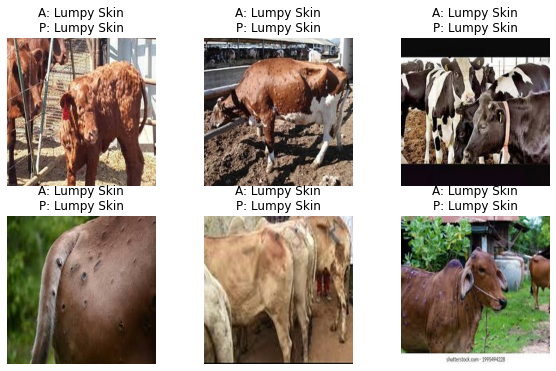

In [31]:
# plot samples
samples = datasets['test'].select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        ax[i,j].imshow(samples[pointer]['image'])
        ax[i,j].set_title(f"A: {labels[samples[pointer]['label']]}\nP: {labels[predictions.label_ids[pointer]]}")
        ax[i,j].axis('off')
        pointer+=1

plt.show()